In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

from PerturbSeq_CMV.paths import DATA_DIR

In [2]:
folder = DATA_DIR / "rawdata" / "CRISPRn_perturb_virus_host_processed"

In [3]:
adata_genesxcells = sc.read_mtx(folder / "matrix.mtx")

Transpose

In [4]:
adata = anndata.AnnData(adata_genesxcells.X.T)
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

**Read metadata**

In [5]:
barcode_path = folder / "barcodes.tsv"
cellidentity_path = folder / "cell_identities.csv"
genes_path = folder /"genes.tsv"

In [6]:
barcodes = pd.read_csv(barcode_path, sep="\t", header=None)
cellidentity = pd.read_csv(cellidentity_path)
genes = pd.read_csv(genes_path, sep="\t", header=None)
genes.columns = ["ENSMBL", "gene ID"]

In [7]:
metadata = pd.read_excel(folder / "CRISPRn_perturb_virus_host_processed.xlsx")
metadata.head()

,cell_barcode,gem_group,UMI_count,guide_UMI_count,guide_read_count,guide_coverage,experimental_time,guide_identity,guide_target,guide_target_organism,guide_phenotype,guide_rank,cell_cycle_phase,viral_load,interferon_score,cluster,UMAP_1,UMAP_2
0,AAACCTGAGAGGTTAT-1,1,13647,89,1818,20.426966,00h,human_IFNAR2_pMH2500,IFNAR2,human,sensitizing,2,G2-M,0.000000,-0.163565,naive,-6.089045,0.183853
1,AAACCTGAGGCGCTCT-1,1,14248,49,969,19.775510,00h,human_BCL2L1_pMH2490,BCL2L1,human,sensitizing,1,S,0.000000,1.386511,infected_1,1.837967,-5.857284
2,AAACCTGAGTCGTACT-1,1,9692,20,295,14.750000,00h,HCMV_UL70_pMH2340,UL70,HCMV,protective,2,M-G1,0.000000,-0.392279,naive,-8.474256,-1.731229
3,AAACCTGAGTGCAAGC-1,1,16595,60,1066,17.766667,00h,HCMV_UL141_pMH2384,UL141,HCMV,protective,2,S,0.000000,-0.209550,naive,-5.834652,-0.998549
4,AAACCTGAGTTCGCGC-1,1,6127,7,160,22.857143,00h,human_IFNAR2_pMH2498,IFNAR2,human,sensitizing,1,G2-M,0.000163,-1.168588,naive,-5.862441,0.085474


Information is both for viral and human reads 

Keep only a fraction of cells 

In [8]:
cells_to_keep = barcodes.loc[barcodes.isin(np.array(metadata.cell_barcode))[0]]
# Get indexes
cells_to_keep_idx = np.array(cells_to_keep.index)

In [9]:
adata = adata[cells_to_keep_idx,:]

In [10]:
adata.obs = metadata

Turn time into float 

In [11]:
metadata.experimental_time = [float(time.split('h')[0]) for time in metadata.experimental_time]

Set metadata df as obs

In [12]:
adata.var = pd.DataFrame(genes)
adata.var.index = adata.var["gene ID"]
adata.var["mt"] = adata.var_names.str.startswith("MT-") 

**Examine metadata**

In [13]:
print(f"Number of targets {len(np.unique(metadata.guide_target))}")

Number of targets 54


In [14]:
np.unique(np.unique(metadata.guide_target))

array(['ASNA1', 'B4GALT7', 'BCL2L1', 'CASP9', 'COG8', 'CSNK2A1', 'CYCS',
       'DDA1', 'EXT2', 'FLCN', 'HS6ST1', 'IFNAR2', 'KIAA1432', 'LAMTOR2',
       'LAMTOR3', 'ORFL150C', 'ORFL151C', 'ORFL152C', 'ORFL253W_(UL112)',
       'ORFL257C', 'PDGFRA', 'RGP1', 'SEC62', 'SLC35B2', 'STAT2', 'UL102',
       'UL105', 'UL115', 'UL119', 'UL121', 'UL122', 'UL123', 'UL135',
       'UL141', 'UL144', 'UL148', 'UL35', 'UL36', 'UL37', 'UL38', 'UL40',
       'UL42', 'UL43', 'UL52', 'UL53', 'UL54', 'UL55', 'UL56', 'UL57',
       'UL69', 'UL70', 'UNC50', 'control-HCMV', 'control-human'],
      dtype=object)

21 factors human, 31 factors virus plus 1 control each

In [15]:
np.unique(metadata.guide_phenotype)

array(['control', 'protective', 'sensitizing'], dtype=object)

Pre-process

In [16]:
highly_expressed_genes = np.array((adata.X.todense().sum(0)>10000).astype(np.bool)).squeeze(0)
print(f"Number of genes with more than 10k counts: {np.sum(highly_expressed_genes)}")
adata.var["highly_variable"] = highly_expressed_genes
sc.pp.normalize_total(adata, np.mean(adata.X.sum(1)))

Number of genes with more than 10k counts: 5172


PCA and UMAP

In [17]:
# PCA
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

In [18]:
sc.pp.neighbors(adata, n_pcs=40)

In [19]:
sc.tl.umap(adata,  min_dist=0.1, spread=1.5)

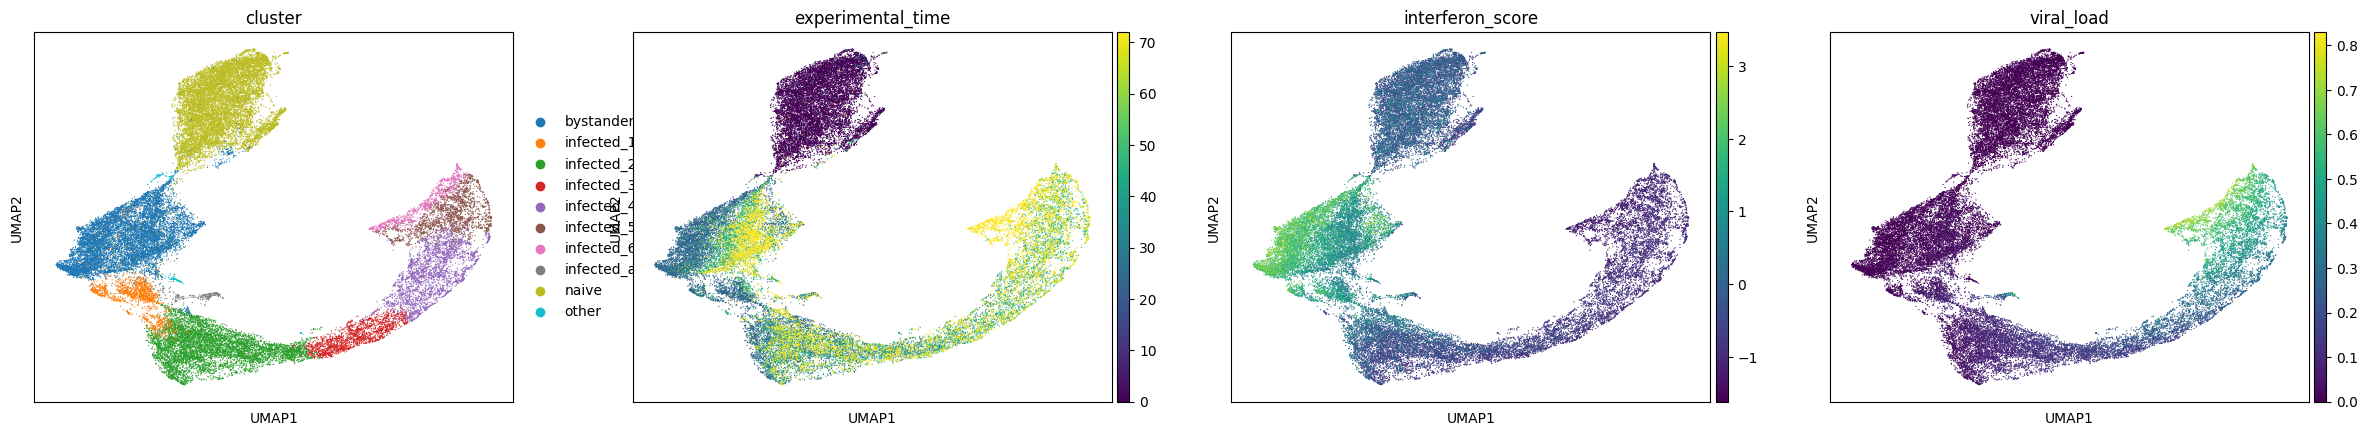

In [20]:
sc.pl.umap(adata, color=["cluster", "experimental_time", "interferon_score", "viral_load"])

**Save the anndata**

In [4]:
processed_data_dir = DATA_DIR / "processed"

In [22]:
adata.write(processed_data_dir / "perturb_seq_host_viral_factors.h5ad")

In [22]:
pd.crosstab(adata.obs["experimental_time"], adata.obs["cluster"])

cluster,bystander,infected_1,infected_2,infected_3,infected_4,infected_5,infected_6,infected_abortive,naive,other
experimental_time,,,,,,,,,,
0.0,190,17,2,0,0,0,0,0,11316,44
24.0,5047,1442,3158,405,140,1,0,98,175,53
48.0,2657,307,2524,973,1587,917,192,86,96,57
72.0,2164,85,1592,575,1213,1128,877,74,79,26


In [23]:
pd.crosstab(adata.obs["guide_target_organism"], adata.obs["cluster"])

cluster,bystander,infected_1,infected_2,infected_3,infected_4,infected_5,infected_6,infected_abortive,naive,other
guide_target_organism,,,,,,,,,,
HCMV,5621,1215,5213,1456,2027,1120,452,162,7188,105
human,4437,636,2063,497,913,926,617,96,4478,75


In [24]:
adata.obs["guide_target_organism"].value_counts()

HCMV     24559
human    14738
Name: guide_target_organism, dtype: int64

In [29]:
adata.obs

,cell_barcode,gem_group,UMI_count,guide_UMI_count,guide_read_count,guide_coverage,experimental_time,guide_identity,guide_target,guide_target_organism,guide_phenotype,guide_rank,cell_cycle_phase,viral_load,interferon_score,cluster,UMAP_1,UMAP_2
0,AAACCTGAGAGGTTAT-1,1,13647,89,1818,20.426966,0.0,human_IFNAR2_pMH2500,IFNAR2,human,sensitizing,2,G2-M,0.000000,-0.163565,naive,-6.089045,0.183853
1,AAACCTGAGGCGCTCT-1,1,14248,49,969,19.775510,0.0,human_BCL2L1_pMH2490,BCL2L1,human,sensitizing,1,S,0.000000,1.386511,infected_1,1.837967,-5.857284
2,AAACCTGAGTCGTACT-1,1,9692,20,295,14.750000,0.0,HCMV_UL70_pMH2340,UL70,HCMV,protective,2,M-G1,0.000000,-0.392279,naive,-8.474256,-1.731229
3,AAACCTGAGTGCAAGC-1,1,16595,60,1066,17.766667,0.0,HCMV_UL141_pMH2384,UL141,HCMV,protective,2,S,0.000000,-0.209550,naive,-5.834652,-0.998549
4,AAACCTGAGTTCGCGC-1,1,6127,7,160,22.857143,0.0,human_IFNAR2_pMH2498,IFNAR2,human,sensitizing,1,G2-M,0.000163,-1.168588,naive,-5.862441,0.085474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39292,TTTGTCAGTACCCAAT-4,4,18017,23,859,37.347826,72.0,HCMV_UL35_pMH2396,UL35,HCMV,sensitizing,2,M-G1,0.439085,-0.935215,infected_4,3.497807,8.963435
39293,TTTGTCATCACGGTTA-4,4,8010,40,1133,28.325000,72.0,human_KIAA1432_pMH2454,KIAA1432,human,protective,1,G2-M,0.013109,0.855164,bystander,-0.522703,-3.375919
39294,TTTGTCATCTAAGCCA-4,4,29561,74,2703,36.527027,72.0,HCMV_UL148_pMH2390,UL148,HCMV,protective,1,G1-S,0.599980,-1.064028,infected_5,-2.328146,10.176273
39295,TTTGTCATCTACCAGA-4,4,31899,40,1003,25.075000,72.0,HCMV_UL121_pMH2366,UL121,HCMV,protective,1,M-G1,0.413587,-1.359114,infected_4,2.323340,8.103360


In [28]:
adata.obs.groupby(["guide_target_organism", "guide_target"]).sum()

gem_group  UMI_count  guide_UMI_count  \
guide_target_organism guide_target                                           
HCMV                  ASNA1                  0          0                0   
                      B4GALT7                0          0                0   
                      BCL2L1                 0          0                0   
                      CASP9                  0          0                0   
                      COG8                   0          0                0   
...                                        ...        ...              ...   
human                 UL144                  0          0                0   
                      UL148                  0          0                0   
                      UNC50                800    3351130            12498   
                      control-HCMV           0          0                0   
                      control-human       2332   14220591            36283   

                                     guide_read_count  guide_coverage  \
guide_target_organism guide_target                                      
HCMV                  ASNA1                         0        0.000000   
                      B4GALT7                       0        0.000000   
                      BCL2L1                        0        0.000000   
                      CASP9                         0        0.000000   
                      COG8                          0        0.000000   
...                                               ...             ...   
human                 UL144                         0        0.000000   
                      UL148                         0        0.000000   
                      UNC50                    353573     9491.990634   
                      control-HCMV                  0        0.000000   
                      control-human            952611    27482.385910   

                                     experimental_time  guide_rank  \
guide_target_organism guide_target                                   
HCMV                  ASNA1                        0.0           0   
                      B4GALT7                      0.0           0   
                      BCL2L1                       0.0           0   
                      CASP9                        0.0           0   
                      COG8                         0.0           0   
...                                                ...         ...   
human                 UL144                        0.0           0   
                      UL148                        0.0           0   
                      UNC50                    11448.0         646   
                      control-HCMV                 0.0           0   
                      control-human            31752.0        1009   

                                     viral_load  interferon_score      UMAP_1  \
guide_target_organism guide_target                                              
HCMV                  ASNA1            0.000000          0.000000    0.000000   
                      B4GALT7          0.000000          0.000000    0.000000   
                      BCL2L1           0.000000          0.000000    0.000000   
                      CASP9            0.000000          0.000000    0.000000   
                      COG8             0.000000          0.000000    0.000000   
...                                         ...               ...         ...   
human                 UL144            0.000000          0.000000    0.000000   
                      UL148            0.000000          0.000000    0.000000   
                      UNC50           13.023347        198.225613 -638.167448   
                      control-HCMV     0.000000          0.000000    0.000000   
                      control-human  140.163274        -99.361502 -935.111922   

                                         UMAP_2  
guide_target_organism guide_target               
HCMV   

In [ ]:
adata.obs["guide_target_organism"].value_counts()

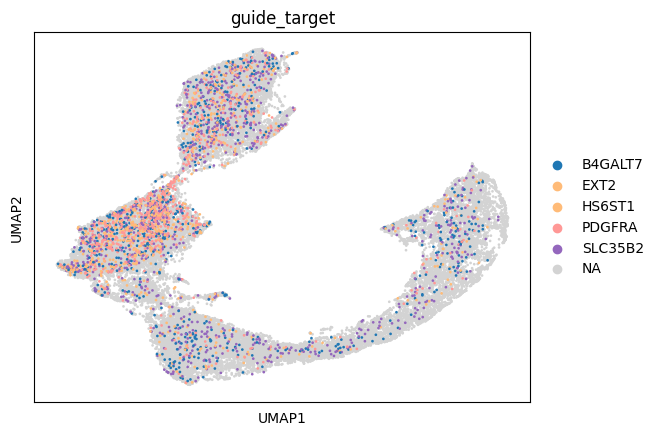

In [41]:
sc.pl.umap(adata, color=["guide_target"], groups=["PDGFRA", "HS6ST1", "SLC35B2", "B4GALT7", "EXT2"], 
           palette="tab20", size=15)

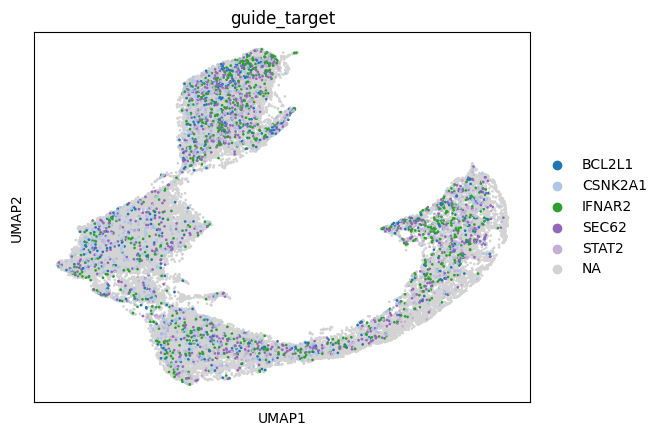

In [47]:
sc.pl.umap(adata, color=["guide_target"], groups=["CSNK2A1", "BCL2L1", "SEC62", "IFNAR2", "STAT2"], 
           palette="tab20", size=15)

**Viral genes knockdowns**

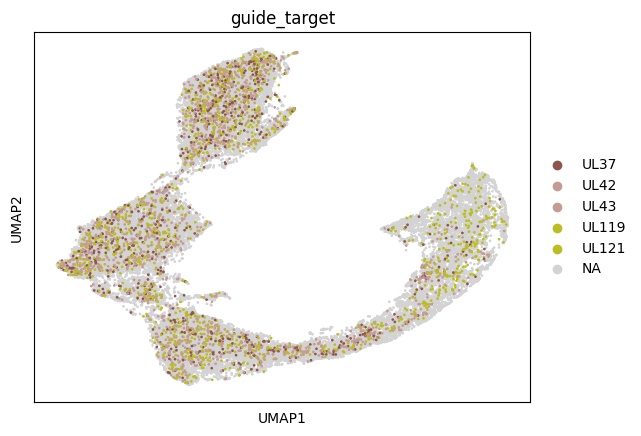

In [55]:
sc.pl.umap(adata, color=["guide_target"], groups=["UL119", "UL121", "UL59", "UL43", "UL42", "UL37"], 
           palette="tab20", size=15)

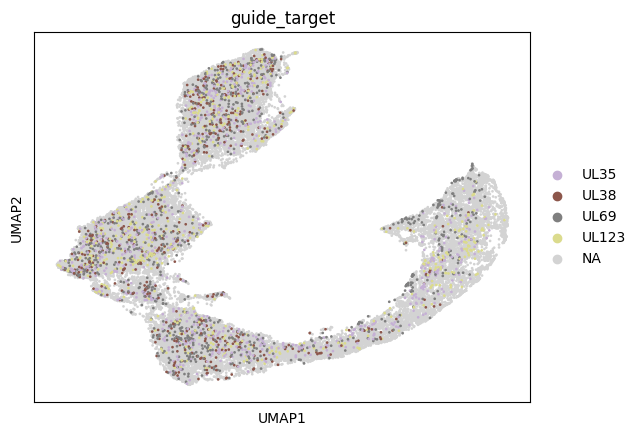

In [60]:
sc.pl.umap(adata, color=["guide_target"], groups=["UL123", "UL112", "UL69", "UL38", "UL35"], 
           palette="tab20", size=15)

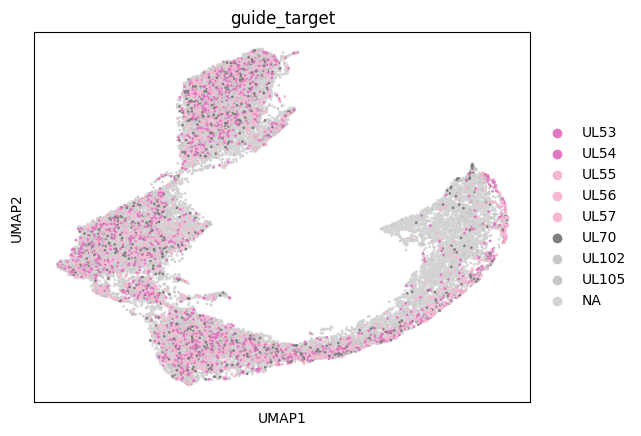

In [62]:
sc.pl.umap(adata, color=["guide_target"], groups=["UL53", "UL54", "UL55", "UL56", "UL57", "UL70", "UL102", "UL105"], 
           palette="tab20", size=15)

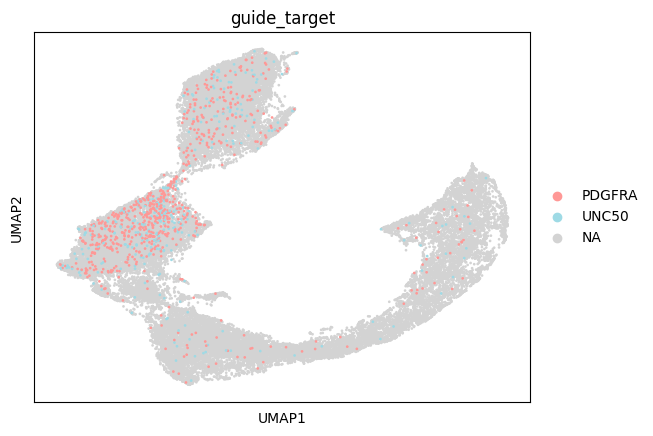

In [66]:
sc.pl.umap(adata, color=["guide_target"], groups=["UNC50", "PDGFRA"], 
           palette="tab20", size=15)